#**Benchmark**

#**Section 1: Import Important Library**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
import pytz
from time import time

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import font_manager
import seaborn as sns
import itertools
import psutil

import cv2
import shutil
import PIL
import os
from pathlib import Path
import sys

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize, LabelEncoder, LabelBinarizer

import random as rd
import numpy as np
import zipfile

In [ ]:
import tensorflow as tf
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

sys.path.append('/content/drive/MyDrive/projectPlant/Colab')
from my_model import *
from helper_functions import *

Mounted at /content/drive


**Detail of Python Notebook in Google Colab**

In [ ]:
!nvidia-smi

import subprocess
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print("-------------------------------------------------------------")
print(f"Python {sys.version}")
print("-------------------------------------------------------------")

# ตรวจสอบ GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Running on GPU")
    strategy = tf.distribute.MirroredStrategy()
    print(f"Number of GPUs Available: {len(gpus)}")

    # ดึงข้อมูล GPU Memory
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=memory.total', '--format=csv,noheader,nounits'],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True
        )
        gpu_memory = result.stdout.strip().split('\n')
        for idx, mem in enumerate(gpu_memory):
            print(f"GPU {idx}: Total Memory: {int(mem) / 1024:.2f} GB")
    except FileNotFoundError:
        print("nvidia-smi is not available on this system.")
else:
    print("No GPU detected. Running on CPU")
    strategy = tf.distribute.get_strategy()

# แสดงจำนวนอุปกรณ์ที่พร้อมใช้งาน
print("Number of replicas:", strategy.num_replicas_in_sync)
print("-------------------------------------------------------------")

# แสดงจำนวน RAM ทั้งหมด
total_ram = psutil.virtual_memory().total / (1024 ** 3)
print(f"Total RAM of Colab instance: {total_ram:.2f} GB")
print("-------------------------------------------------------------")

# แสดงเวลาปัจจุบันในเขตเวลาไทย
thailand_tz = pytz.timezone('Asia/Bangkok')
current_time = datetime.now(thailand_tz).strftime("%Y-%m-%d %H:%M:%S")
print("Current Time (Thailand):", current_time)

Thu Aug 28 04:31:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**Initialize Setting (Focus First)**

In [ ]:
SEED=42
np.random.seed(SEED)
tf.random.set_seed(SEED)
rd.seed(SEED)
BATCH_SIZE = 64

In [ ]:
root_dir = '/content/drive/MyDrive/projectPlant/'
title = 'PlantVillage Dataset'
dataset_name = 'plantVillageDataset'
dataset_dir = root_dir + dataset_name

In [ ]:
current_dir = os.getcwd()

In [ ]:
zip_filename = 'plantVillage_dataset_raw.zip'
zip_dir = dataset_dir + '/' + zip_filename

with zipfile.ZipFile(zip_dir, 'r') as zip_ref: # แตกไฟล์จาก G-Drive มาที่ Runtime Directory
    zip_ref.extractall(current_dir)
print(f"Unzip complete at {current_dir}")

Unzip complete at /content


In [ ]:
locations = [f"{root_dir}Extra2/Font"]
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(font_files[0])
for file in font_files:
  font_manager.fontManager.addfont(file)

/content/drive/MyDrive/projectPlant/Extra2/Font/OPTITimes-Roman.otf


#**Section 2: Load Dataset**

In [ ]:
model_name = 'MBNv3Small_Modify_A'
otmz_name = 'Adam'
seed_num = f"{SEED}"
rounds_num = '1'

In [ ]:
img_dir = root_dir + 'Extra2/' + dataset_name
sample_img_dir = img_dir + '/SampleImages'
img_each_model_dir = img_dir + '/' + model_name + '_' + dataset_name + '_' + otmz_name + '_' + seed_num + '(' + rounds_num + ')'
excel_dir = root_dir + 'DatasetSetting/' + dataset_name + '/' + 'split_data_seed_' + seed_num + '.xlsx'

In [ ]:
os.makedirs(img_dir, exist_ok=True)
os.makedirs(sample_img_dir, exist_ok=True)
os.makedirs(img_each_model_dir, exist_ok=True)

#**Section 3: Placing data into a Dataframe**

##**Convert to dataframe**

In [ ]:
TRAIN_DF, VALID_DF, TEST_DF = to_dataframe_excel(path=excel_dir, sheet_name='Split-Data', mode='single', condition=False, labels_mapping=None)

In [ ]:
print(f"Train Dataframe\n")
print(f"Total images: {len(TRAIN_DF)}")
print(f"Total classes: {TRAIN_DF['Label'].nunique()}")
TRAIN_DF

Train Dataframe

Total images: 13208
Total classes: 15


,Filepath,Label,Original_Index
0,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Bacterial_spot,5751
1,/content/drive/MyDrive/projectPlant/plantVilla...,Pepper__bell___healthy,2155
2,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato__Tomato_YellowLeaf__Curl_Virus,16158
3,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Bacterial_spot,5024
4,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Late_blight,8809
...,...,...,...
13203,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Leaf_Mold,9751
13204,/content/drive/MyDrive/projectPlant/plantVilla...,Potato___Late_blight,4241
13205,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Early_blight,7601
13206,/content/drive/MyDrive/projectPlant/plantVilla...,Pepper__bell___healthy,2218


In [ ]:
TRAIN_DF["Filepath"] = TRAIN_DF["Filepath"].str.replace(
    "/content/drive/MyDrive/projectPlant/",
    "/content/"
)
TRAIN_DF

,Filepath,Label,Original_Index
0,/content/plantVillageDataset/Tomato_Bacterial_...,Tomato_Bacterial_spot,5751
1,/content/plantVillageDataset/Pepper__bell___he...,Pepper__bell___healthy,2155
2,/content/plantVillageDataset/Tomato__Tomato_Ye...,Tomato__Tomato_YellowLeaf__Curl_Virus,16158
3,/content/plantVillageDataset/Tomato_Bacterial_...,Tomato_Bacterial_spot,5024
4,/content/plantVillageDataset/Tomato_Late_bligh...,Tomato_Late_blight,8809
...,...,...,...
13203,/content/plantVillageDataset/Tomato_Leaf_Mold/...,Tomato_Leaf_Mold,9751
13204,/content/plantVillageDataset/Potato___Late_bli...,Potato___Late_blight,4241
13205,/content/plantVillageDataset/Tomato_Early_blig...,Tomato_Early_blight,7601
13206,/content/plantVillageDataset/Pepper__bell___he...,Pepper__bell___healthy,2218


In [ ]:
print(f"Validation Dataframe\n")
print(f"Total images: {len(VALID_DF)}")
print(f"Total classes: {VALID_DF['Label'].nunique()}")
VALID_DF

Validation Dataframe

Total images: 3302
Total classes: 15


,Filepath,Label,Original_Index
0,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato__Tomato_YellowLeaf__Curl_Virus,15877
1,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Spider_mites_Two_spotted_spider_mite,13525
2,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_healthy,19272
3,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato__Tomato_YellowLeaf__Curl_Virus,16427
4,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato__Target_Spot,14005
...,...,...,...
3297,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato__Target_Spot,14105
3298,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Bacterial_spot,6432
3299,/content/drive/MyDrive/projectPlant/plantVilla...,Pepper__bell___Bacterial_spot,60
3300,/content/drive/MyDrive/projectPlant/plantVilla...,Potato___healthy,4523


In [ ]:
VALID_DF["Filepath"] = VALID_DF["Filepath"].str.replace(
    "/content/drive/MyDrive/projectPlant/",
    "/content/"
)
VALID_DF

,Filepath,Label,Original_Index
0,/content/plantVillageDataset/Tomato__Tomato_Ye...,Tomato__Tomato_YellowLeaf__Curl_Virus,15877
1,/content/plantVillageDataset/Tomato_Spider_mit...,Tomato_Spider_mites_Two_spotted_spider_mite,13525
2,/content/plantVillageDataset/Tomato_healthy/98...,Tomato_healthy,19272
3,/content/plantVillageDataset/Tomato__Tomato_Ye...,Tomato__Tomato_YellowLeaf__Curl_Virus,16427
4,/content/plantVillageDataset/Tomato__Target_Sp...,Tomato__Target_Spot,14005
...,...,...,...
3297,/content/plantVillageDataset/Tomato__Target_Sp...,Tomato__Target_Spot,14105
3298,/content/plantVillageDataset/Tomato_Bacterial_...,Tomato_Bacterial_spot,6432
3299,/content/plantVillageDataset/Pepper__bell___Ba...,Pepper__bell___Bacterial_spot,60
3300,/content/plantVillageDataset/Potato___healthy/...,Potato___healthy,4523


In [ ]:
print(f"Test Dataframe\n")
print(f"Total images: {len(TEST_DF)}")
print(f"Total classes: {TEST_DF['Label'].nunique()}")
TEST_DF

Test Dataframe

Total images: 4128
Total classes: 15


,Filepath,Label,Original_Index
0,/content/drive/MyDrive/projectPlant/plantVilla...,Potato___Early_blight,2655
1,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Spider_mites_Two_spotted_spider_mite,12257
2,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Late_blight,8851
3,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Spider_mites_Two_spotted_spider_mite,12831
4,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Late_blight,9140
...,...,...,...
4123,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_healthy,19299
4124,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Leaf_Mold,9885
4125,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Late_blight,7976
4126,/content/drive/MyDrive/projectPlant/plantVilla...,Tomato_Bacterial_spot,5742


In [ ]:
TEST_DF["Filepath"] = TEST_DF["Filepath"].str.replace(
    "/content/drive/MyDrive/projectPlant/",
    "/content/"
)
TEST_DF

,Filepath,Label,Original_Index
0,/content/plantVillageDataset/Potato___Early_bl...,Potato___Early_blight,2655
1,/content/plantVillageDataset/Tomato_Spider_mit...,Tomato_Spider_mites_Two_spotted_spider_mite,12257
2,/content/plantVillageDataset/Tomato_Late_bligh...,Tomato_Late_blight,8851
3,/content/plantVillageDataset/Tomato_Spider_mit...,Tomato_Spider_mites_Two_spotted_spider_mite,12831
4,/content/plantVillageDataset/Tomato_Late_bligh...,Tomato_Late_blight,9140
...,...,...,...
4123,/content/plantVillageDataset/Tomato_healthy/9d...,Tomato_healthy,19299
4124,/content/plantVillageDataset/Tomato_Leaf_Mold/...,Tomato_Leaf_Mold,9885
4125,/content/plantVillageDataset/Tomato_Late_bligh...,Tomato_Late_blight,7976
4126,/content/plantVillageDataset/Tomato_Bacterial_...,Tomato_Bacterial_spot,5742


#**Section 4: Data Preparing**

In [ ]:
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = (224, 224, 3)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet_v3.preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest'
)

valid_test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=keras.applications.mobilenet_v3.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe = TRAIN_DF,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

val_images = valid_test_generator.flow_from_dataframe(
    dataframe = VALID_DF,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed = SEED
)

test_images = valid_test_generator.flow_from_dataframe(
    dataframe = TEST_DF,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = IMAGE_SIZE,
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = False
)

Found 13208 validated image filenames belonging to 15 classes.
Found 3302 validated image filenames belonging to 15 classes.
Found 4128 validated image filenames belonging to 15 classes.


#**Section 5: Preparing the Model**

In [ ]:
checkpoint_path, save_path_h5, save_path_keras, save_path_json, save_path_history, save_path_tensorboard = save_path(otmz_name=otmz_name, dataset_name=dataset_name, rounds=rounds_num, model=model_name, seed=SEED)
print("Recheck save path: \n")
print(f"Checkpoint path: {checkpoint_path}")
print(f"Save path h5: {save_path_h5}")
print(f"Save path keras: {save_path_keras}")
print(f"Save path json: {save_path_json}")
print(f"Save path history: {save_path_history}")
print(f"Save path tensorboard: {save_path_tensorboard}")

Recheck save path: 

Checkpoint path: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Modify_A/plantVillageDataset_42(1)/Adam/MBNv3Small_Modify_A_plantVillageDataset_Adam_42(1)_best.keras
Save path h5: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Modify_A/plantVillageDataset_42(1)/Adam/MBNv3Small_Modify_A_plantVillageDataset_Adam_42(1).h5
Save path keras: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Modify_A/plantVillageDataset_42(1)/Adam/MBNv3Small_Modify_A_plantVillageDataset_Adam_42(1).keras
Save path json: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Modify_A/plantVillageDataset_42(1)/Adam/MBNv3Small_Modify_A_plantVillageDataset_Adam_42(1).json
Save path history: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Modify_A/plantVillageDataset_42(1)/Adam/MBNv3Small_Modify_A_plantVillageDataset_Adam_42(1).csv
Save path tensorboard: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Modify_A/plantVillageDataset_42(1)/Adam/M

##**Create Model Callback**

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path,
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = False,
    mode = 'auto'
)

class LearningRateTracker(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        # Access learning rate through learning_rate property
        lr = self.model.optimizer.learning_rate.numpy()  # This will now work correctly
        logs = logs or {}
        logs['lr'] = lr

        if not hasattr(self, 'learning_rates'):
            self.learning_rates = []
        self.learning_rates.append(lr)

# Create the callback instance
lr_tracker = LearningRateTracker()

tensorlog = keras.callbacks.TensorBoard(
    log_dir = save_path_tensorboard,
    histogram_freq = 1,
    write_graph = True,
    write_images = True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 5,
    verbose = 1,
    min_lr = 1e-06
)

##**Model Parameters**

In [ ]:
chao_kuay_model = build_model(model_name="MobileNetV3Small_Modify_A", input_shape=IMAGE_SHAPE, num_classes=len(train_images.class_indices))
chao_kuay_model.compile(
    optimizer = keras.optimizers.Adam(
        learning_rate = 1e-04,
        beta_1 = 0.9,
        beta_2 = 0.999,
        epsilon = 1e-07,
        name = 'Adam'
    ),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)
chao_kuay_model.summary()

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 924,735 (3.53 MB)

 Trainable params: 698,199 (2.66 MB)

 Non-trainable params: 226,536 (884.91 KB)

#**Section 6: Training the model**

In [ ]:
start_time_training = time()

history = chao_kuay_model.fit(
    x = train_images,
    validation_data = val_images,
    batch_size = BATCH_SIZE,
    callbacks = [model_checkpoint, tensorlog, lr_tracker, reduce_lr],
    epochs = 30,
)

end_time_training = time()

Epoch 1/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 940ms/step - accuracy: 0.5521 - loss: 1.5807
Epoch 1: val_accuracy improved from -inf to 0.89431, saving model to /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Modify_A/plantVillageDataset_42(1)/Adam/MBNv3Small_Modify_A_plantVillageDataset_Adam_42(1)_best.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.5529 - loss: 1.5778 - val_accuracy: 0.8943 - val_loss: 0.3322 - learning_rate: 1.0000e-04
Epoch 2/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 901ms/step - accuracy: 0.8963 - loss: 0.3323
Epoch 2: val_accuracy improved from 0.89431 to 0.93247, saving model to /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Modify_A/plantVillageDataset_42(1)/Adam/MBNv3Small_Modify_A_plantVillageDataset_Adam_42(1)_best.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 223s 949ms/step - accuracy: 0.8964 - loss: 0.3322 - val_accuracy: 0.9325 - val_loss: 0.2135 - learning_rate: 1.0000e-04
Epoch 3/30
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.

In [ ]:
history_dict = history.history
print(f"History: {history_dict}")

History: {'accuracy': [0.7219866514205933, 0.9052847027778625, 0.9350393414497375, 0.9454118609428406, 0.9566171765327454, 0.9597213864326477, 0.9644911885261536, 0.9712295532226562, 0.972289502620697, 0.9756965637207031, 0.9757722616195679, 0.9783464670181274, 0.9796335697174072, 0.981450617313385, 0.9835705757141113, 0.9847062230110168, 0.9844033718109131, 0.9861447811126709, 0.9875075817108154, 0.9872047305107117, 0.9891732335090637, 0.9893246293067932, 0.9892489314079285, 0.9887189865112305, 0.9884161353111267, 0.9884918332099915, 0.9882646799087524, 0.9915202856063843, 0.990838885307312, 0.9929587841033936], 'loss': [0.9767097234725952, 0.29596003890037537, 0.20273920893669128, 0.16743811964988708, 0.13341352343559265, 0.11470898985862732, 0.10736127197742462, 0.08550771325826645, 0.08209335803985596, 0.07227756828069687, 0.07153385877609253, 0.06380762904882431, 0.0593533031642437, 0.05312725529074669, 0.04992007091641426, 0.04666091129183769, 0.046455349773168564, 0.041875965893

In [ ]:
training_time = end_time_training - start_time_training
hours, remainder = divmod(training_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Training time: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

Training time: 1 hours, 40 minutes, 16.50 seconds


##**Save the model**

In [ ]:
save_epoch_history(history, save_path_history)

History has been saved to: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Modify_A/plantVillageDataset_42(1)/Adam/MBNv3Small_Modify_A_plantVillageDataset_Adam_42(1).csv


In [ ]:
save_model(chao_kuay_model, save_path_h5, save_path_keras, save_path_json)

Model has been saved to: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Modify_A/plantVillageDataset_42(1)/Adam/MBNv3Small_Modify_A_plantVillageDataset_Adam_42(1).keras
Model has been saved to: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Modify_A/plantVillageDataset_42(1)/Adam/MBNv3Small_Modify_A_plantVillageDataset_Adam_42(1).h5
Model has been saved to: /content/drive/MyDrive/projectPlant/modelTest2/MBNv3Small_Modify_A/plantVillageDataset_42(1)/Adam/MBNv3Small_Modify_A_plantVillageDataset_Adam_42(1).json


#**Section 7: Model Evaluation**

In [ ]:
start_time_evaluate = time()
test_acc = chao_kuay_model.evaluate(test_images, verbose=1)
print(f"Final Test Accuracy: {test_acc[1]}, Final Test Loss: {test_acc[0]}")
end_time_evaluate = time()
evaluate_time = end_time_evaluate - start_time_evaluate
hours, remainder = divmod(evaluate_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Evaluation time: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

65/65 ━━━━━━━━━━━━━━━━━━━━ 16s 241ms/step - accuracy: 0.9808 - loss: 0.0583
Final Test Accuracy: 0.981589138507843, Final Test Loss: 0.05345625802874565
Evaluation time: 0 hours, 0 minutes, 15.89 seconds


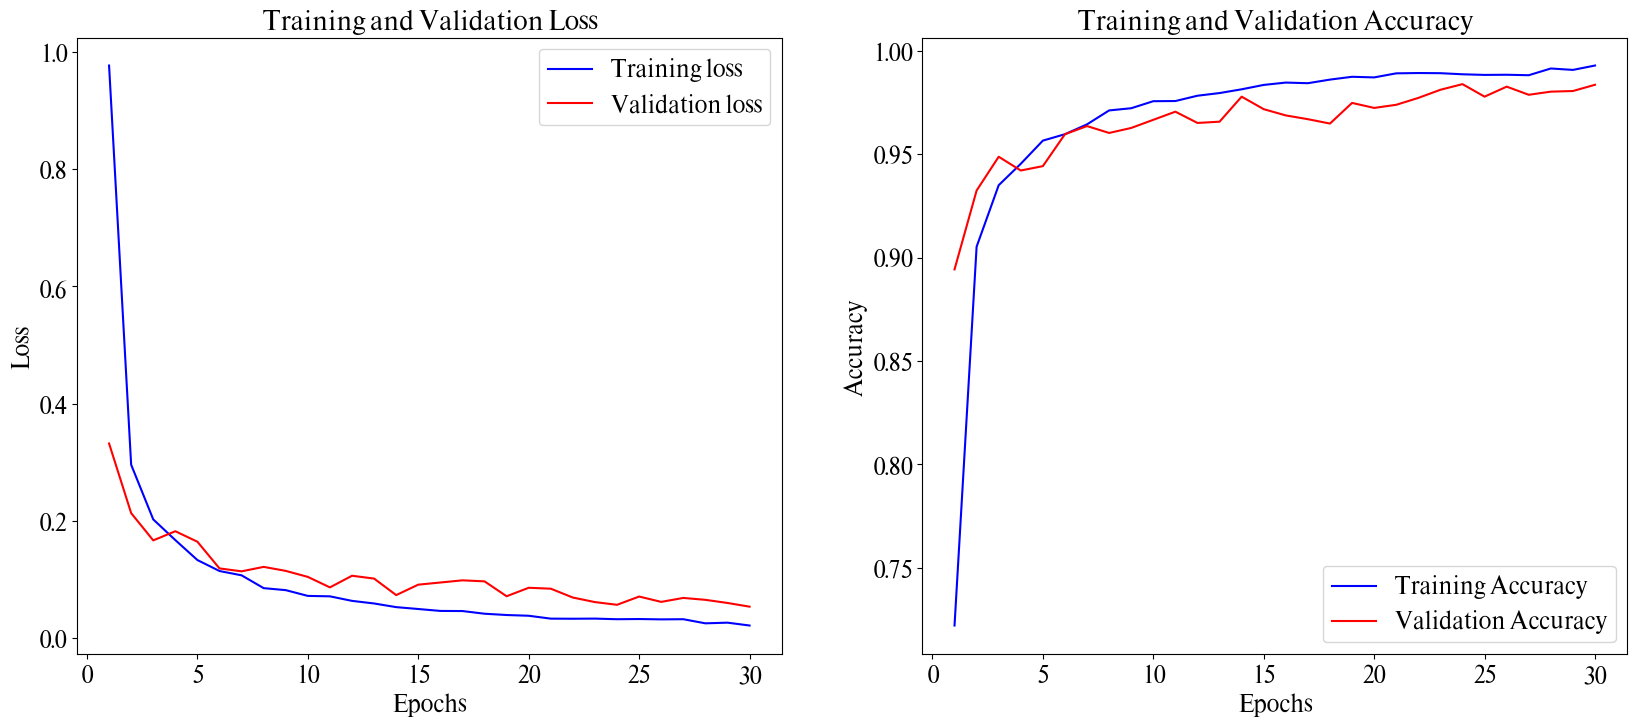

In [ ]:
tr_plot_no_best_epoch(history, 0, paths=img_each_model_dir)

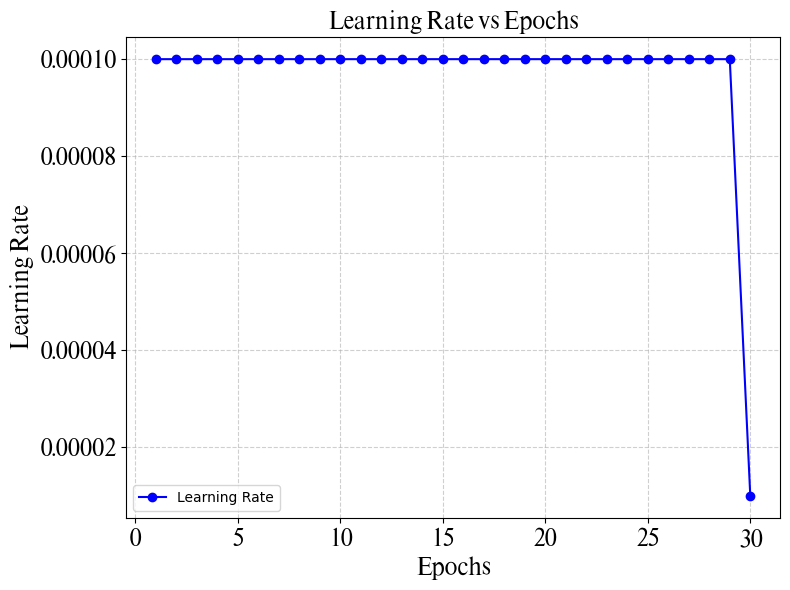

In [ ]:
lr_plot(lr_tracker, history, paths=img_each_model_dir)

#**Section 8: Making predictions on the Predict Data**

In [ ]:
# พยากรณ์ผลลัพธ์จากโมเดล
predictions = chao_kuay_model.predict(test_images)
# แปลงผลลัพธ์เป็น index ของ class ที่มีค่าความน่าจะเป็นสูงสุด
predicted_indices = np.argmax(predictions, axis=1)
# ดึงข้อมูล mapping ระหว่าง index กับ class name จาก training set
class_index_mapping = train_images.class_indices
# สลับ key กับ value เพื่อแปลงจาก index กลับไปเป็นชื่อ class
index_to_class = dict((v, k) for k, v in class_index_mapping.items())
# แปลง predicted index ให้เป็นชื่อ class ที่เกี่ยวข้อง
predicted_classes = [index_to_class[index] for index in predicted_indices]

65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 194ms/step


##**Misclass Predicted**

In [ ]:
incorrect_index = [i for i in range(len(TEST_DF)) if TEST_DF.Label.iloc[i] != predicted_classes[i]]

# สร้าง DataFrame ใหม่ที่มีเฉพาะแถวที่ทำนายผิด
misclassified_df = TEST_DF.iloc[incorrect_index].copy()
# เพิ่มคอลัมน์ Predicted Label ลงใน DataFrame
misclassified_df['Predicted Label'] = [predicted_classes[i] for i in incorrect_index]  # เปลี่ยนชื่อให้ตรงกับที่ต้องการ
# เลือกคอลัมน์ Filepath, Label (True Label), และ Predicted Label
result_misclass_df = misclassified_df[['Filepath', 'Label', 'Predicted Label']]
# เปลี่ยนชื่อคอลัมน์ Label เป็น True Label
result_misclass_df = result_misclass_df.rename(columns={'Label': 'True Label'})

print("Misclassified Dataframe Detail:")
result_misclass_df

Misclassified Dataframe Detail:


,Filepath,True Label,Predicted Label
93,/content/plantVillageDataset/Tomato_Spider_mit...,Tomato_Spider_mites_Two_spotted_spider_mite,Tomato__Target_Spot
97,/content/plantVillageDataset/Tomato_Bacterial_...,Tomato_Bacterial_spot,Tomato_Spider_mites_Two_spotted_spider_mite
134,/content/plantVillageDataset/Tomato_Septoria_l...,Tomato_Septoria_leaf_spot,Tomato__Target_Spot
166,/content/plantVillageDataset/Tomato__Tomato_Ye...,Tomato__Tomato_YellowLeaf__Curl_Virus,Tomato_Bacterial_spot
174,/content/plantVillageDataset/Pepper__bell___he...,Pepper__bell___healthy,Tomato_healthy
...,...,...,...
3895,/content/plantVillageDataset/Tomato_Spider_mit...,Tomato_Spider_mites_Two_spotted_spider_mite,Tomato__Target_Spot
3913,/content/plantVillageDataset/Tomato_Early_blig...,Tomato_Early_blight,Tomato__Tomato_YellowLeaf__Curl_Virus
3950,/content/plantVillageDataset/Tomato__Target_Sp...,Tomato__Target_Spot,Tomato_Spider_mites_Two_spotted_spider_mite
3978,/content/plantVillageDataset/Tomato__Target_Sp...,Tomato__Target_Spot,Tomato_Spider_mites_Two_spotted_spider_mite


In [ ]:
y_test = list(TEST_DF.Label)
report = classification_report(y_test, predicted_classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Pepper__bell___Bacterial_spot,0.994872,0.974874,0.984772,199.000000
Pepper__bell___healthy,0.980066,0.996622,0.988275,296.000000
Potato___Early_blight,1.000000,0.995000,0.997494,200.000000
Potato___Late_blight,0.975124,0.980000,0.977556,200.000000
Potato___healthy,0.935484,0.966667,0.950820,30.000000
Tomato_Bacterial_spot,0.992857,0.978873,0.985816,426.000000
Tomato_Early_blight,0.949239,0.935000,0.942065,200.000000
Tomato_Late_blight,0.979058,0.979058,0.979058,382.000000
Tomato_Leaf_Mold,1.000000,0.984211,0.992042,190.000000
Tomato_Septoria_leaf_spot,0.985673,0.971751,0.978663,354.000000


##**Plot ROC Curve**

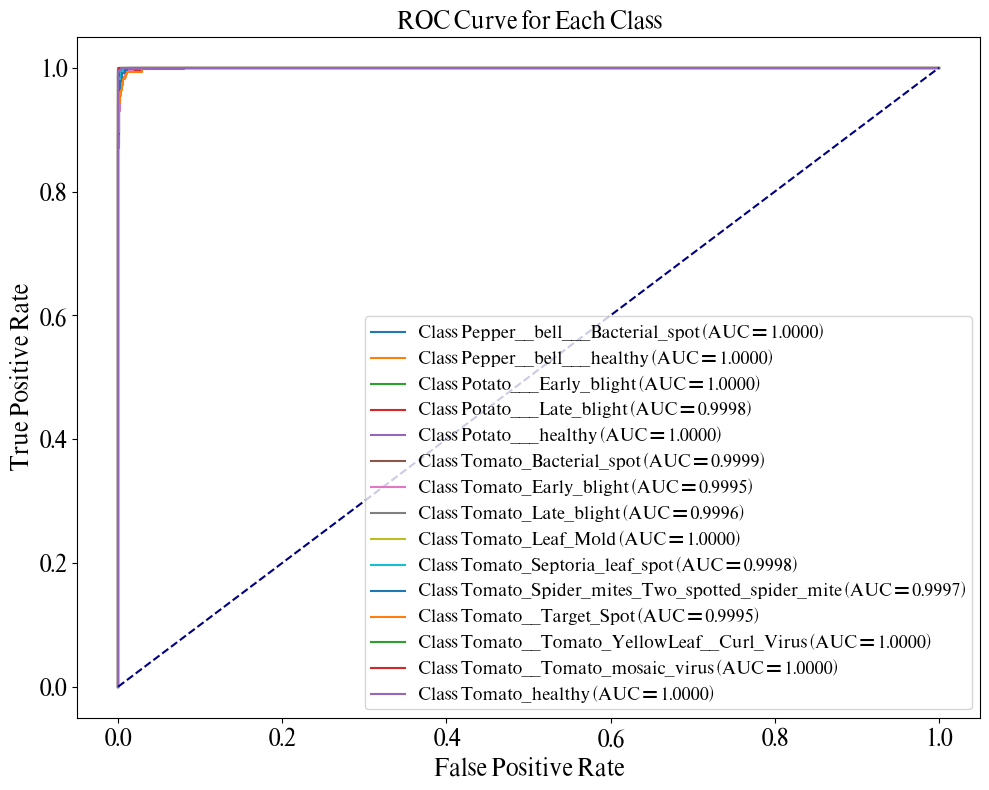

In [ ]:
plot_roc_curve(y_test, predictions, paths=img_each_model_dir)

##**Plot Confusion Matrix**

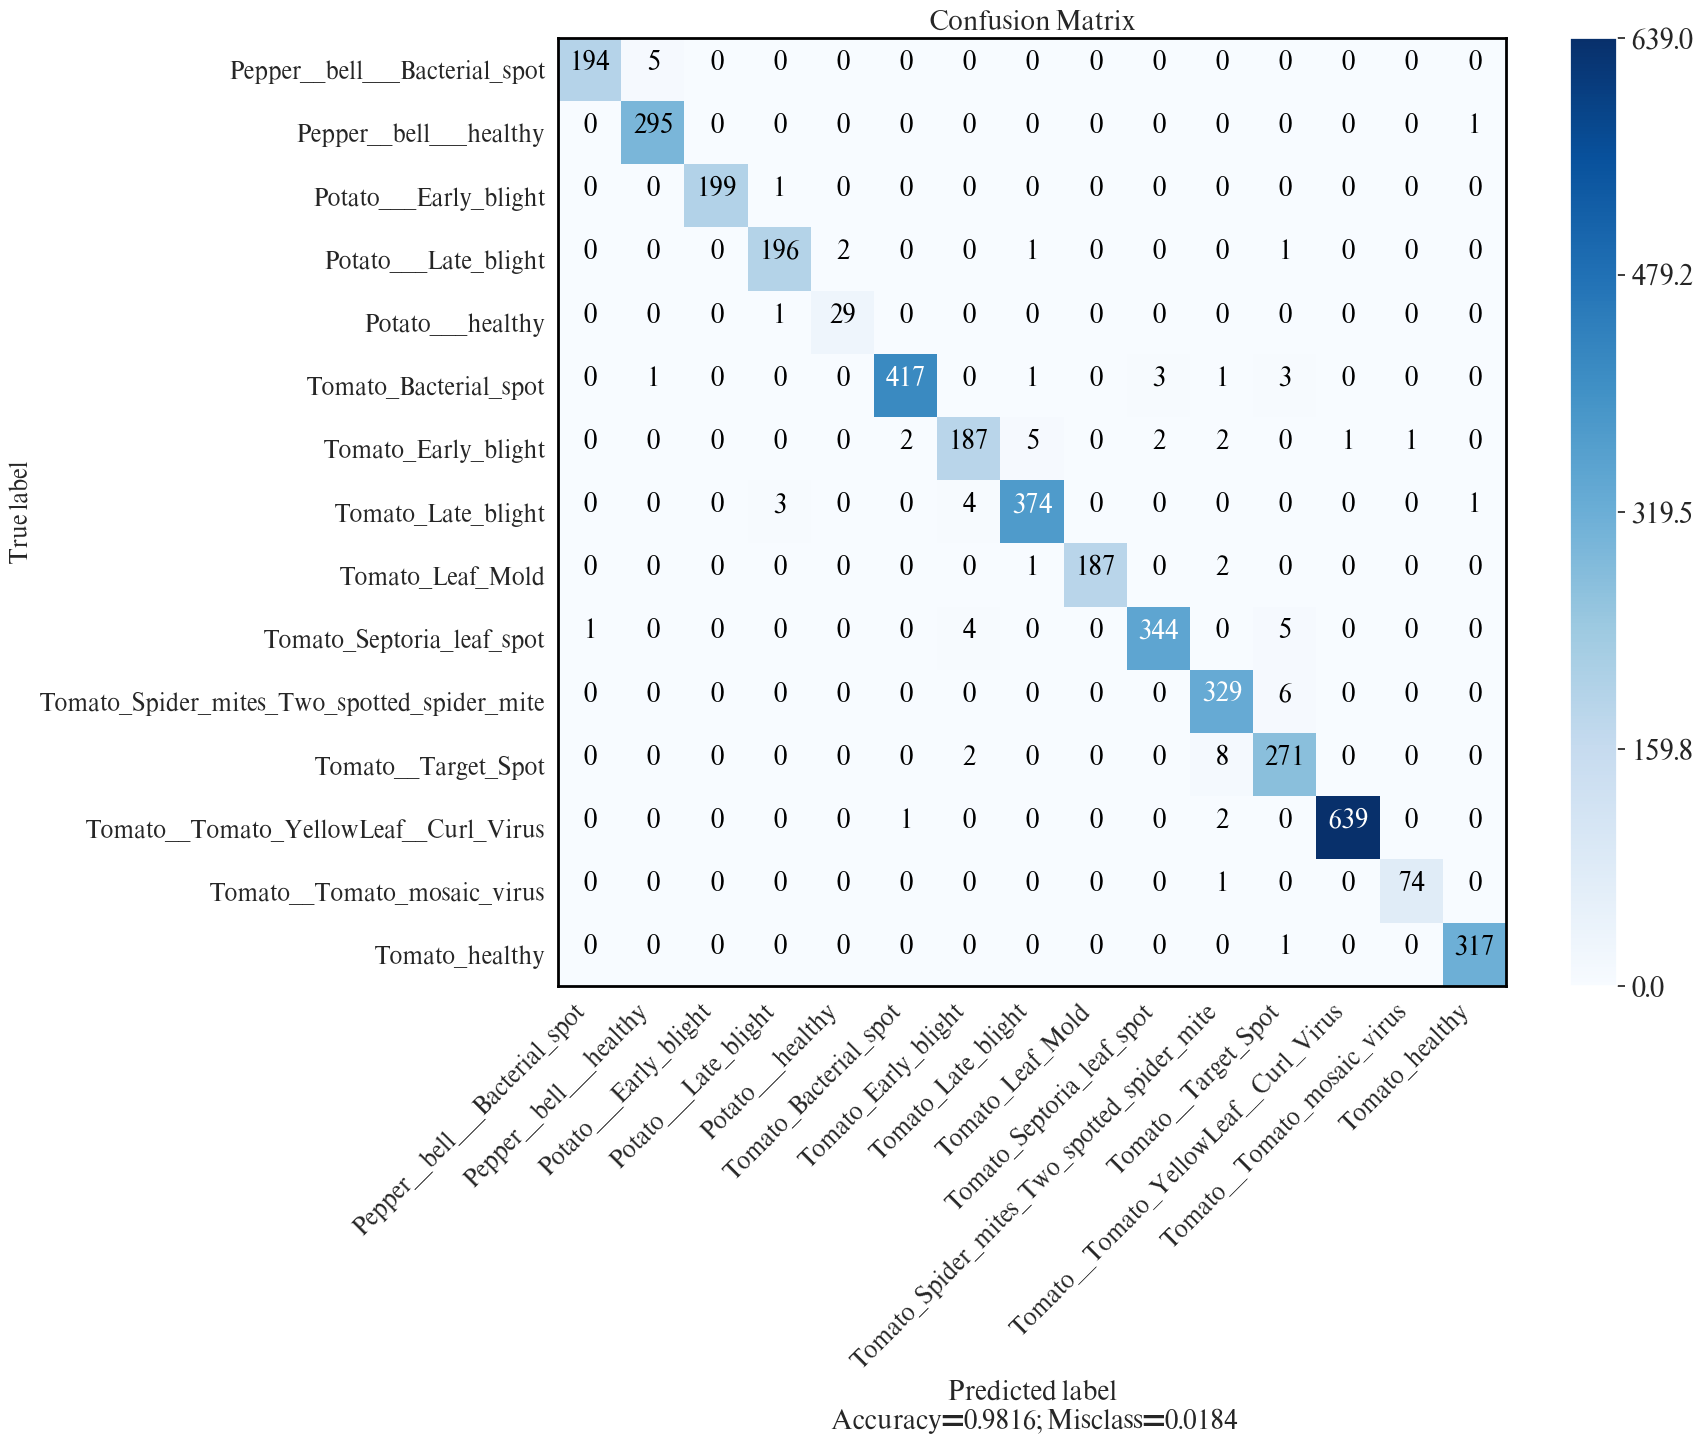

In [ ]:
target_names = list(index_to_class.values())
cm = confusion_matrix(y_test, predicted_classes)
plot_confusion_matrix(cm=cm, target_names=target_names, title='Confusion Matrix', fontsize=16, paths=img_each_model_dir)

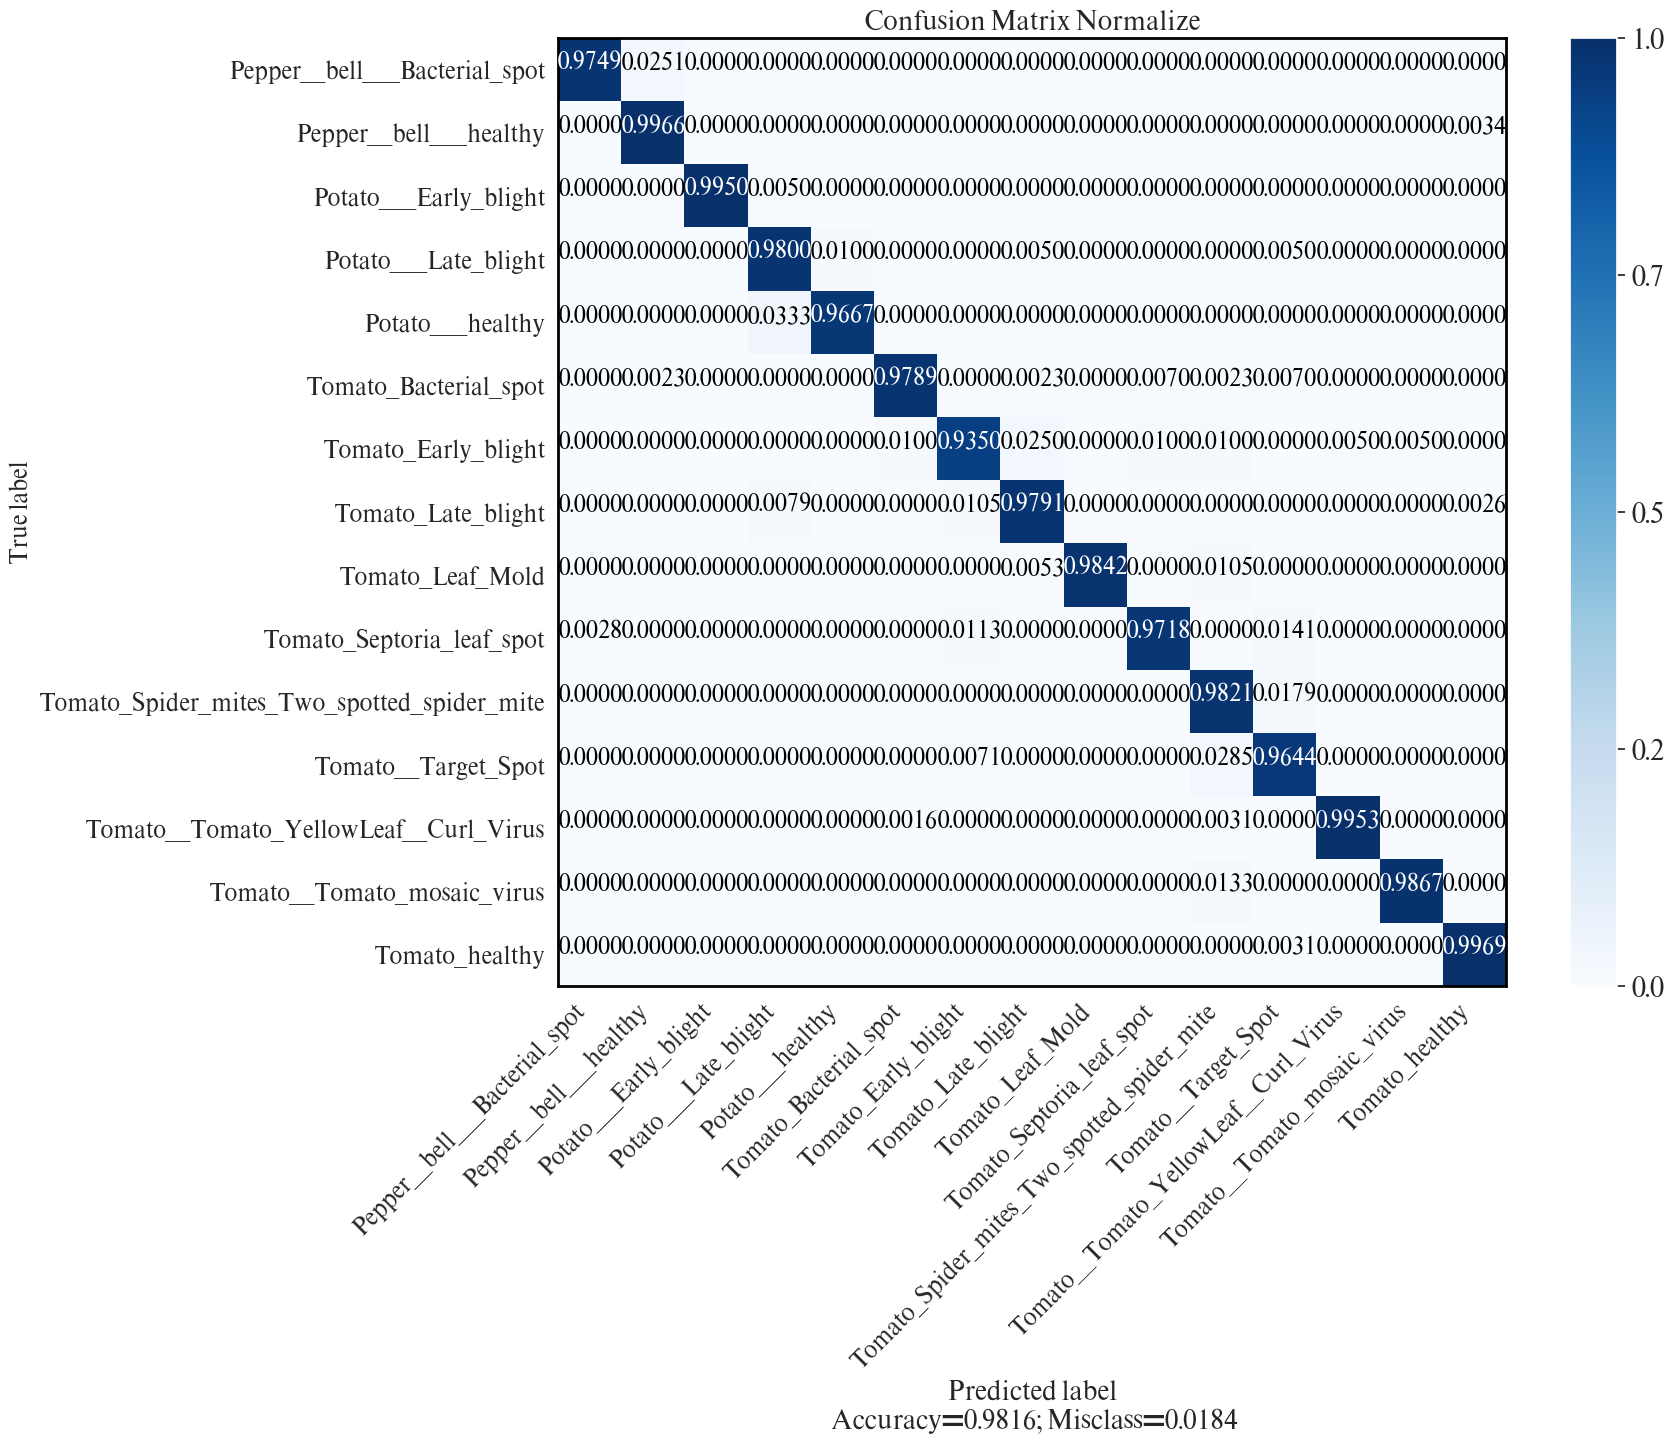

In [ ]:
plot_confusion_matrix(cm=cm, target_names=target_names, title='Confusion Matrix Normalize', normalize = True, fontsize=16, paths=img_each_model_dir)

##**Load Model Test**

In [ ]:
load_model = keras.saving.load_model(save_path_keras)

In [ ]:
start_time_evaluate = time()
test_acc_load = load_model.evaluate(test_images, verbose=1)
print(f"Final Test Accuracy: {test_acc_load[1]}, Final Test Loss: {test_acc_load[0]}")
end_time_evaluate = time()
evaluate_time = end_time_evaluate - start_time_evaluate
hours, remainder = divmod(evaluate_time, 3600)
minutes, seconds = divmod(remainder, 60)
print(f"Evaluation time: {int(hours)} hours, {int(minutes)} minutes, {seconds:.2f} seconds")

65/65 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - accuracy: 0.9808 - loss: 0.0583
Final Test Accuracy: 0.981589138507843, Final Test Loss: 0.05345625802874565
Evaluation time: 0 hours, 0 minutes, 17.70 seconds
